In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

TEST_SIZE = 0.2
RANDOM_STATE = 42

In [3]:
from sklift.datasets import fetch_criteo

data, outcome, treatment = fetch_criteo(
    target_col='conversion', treatment_col='exposure', return_X_y_t=True, data_home="../data/", download_if_missing=True
)

Criteo dataset:   0%|          | 0.00/311M [00:00<?, ?iB/s]

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(
    data, treatment, outcome, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)
X_train.shape, X_test.shape, t_train.shape, t_test.shape, y_train.shape, y_test.shape

((11183673, 12),
 (2795919, 12),
 (11183673,),
 (2795919,),
 (11183673,),
 (2795919,))

## S-learner

In [5]:
from causalml.inference.meta import BaseSClassifier
from lightgbm import LGBMClassifier

model_s = BaseSClassifier(
    learner=LGBMClassifier()
)
model_s.fit(X_train, t_train, y_train)

[LightGBM] [Info] Number of positive: 32533, number of negative: 11151140
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.196412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1698
[LightGBM] [Info] Number of data points in the train set: 11183673, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002909 -> initscore=-5.837042
[LightGBM] [Info] Start training from score -5.837042


In [6]:
tau_test = model_s.predict(X_test)
tau_test.shape

/Users/abasu/Library/Caches/pypoetry/virtualenvs/uplift-model-talk-q0W7Gepo-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/abasu/Library/Caches/pypoetry/virtualenvs/uplift-model-talk-q0W7Gepo-py3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


(2795919, 1)

In [7]:
y_test.value_counts()

conversion
0    2787678
1       8241
Name: count, dtype: Int64

In [8]:
eval_df = pd.DataFrame({
    "tau": tau_test.reshape(-1),
    "t": t_test,
    "y": y_test
})


In [9]:
eval_df

,tau,t,y
6540047,0.007469,0,0
12657168,0.018831,0,0
9588964,0.010479,0,0
4905360,0.014384,0,0
7937047,0.011490,0,0
...,...,...,...
8857146,0.011250,0,0
589961,0.021185,0,0
12273368,0.010461,0,0
11278345,0.163049,0,0


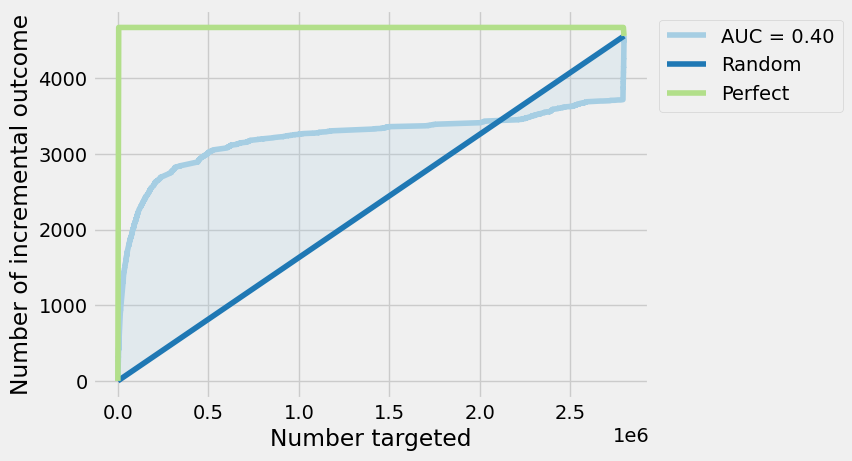

In [13]:
from src.viz import plot_qini_curve

plot_qini_curve(
    eval_df["y"],
    eval_df["tau"],
    eval_df["t"],
)

<Axes: title={'center': 'Uplift Bins'}, xlabel='Bin', ylabel='Actual Uplift Mean'>

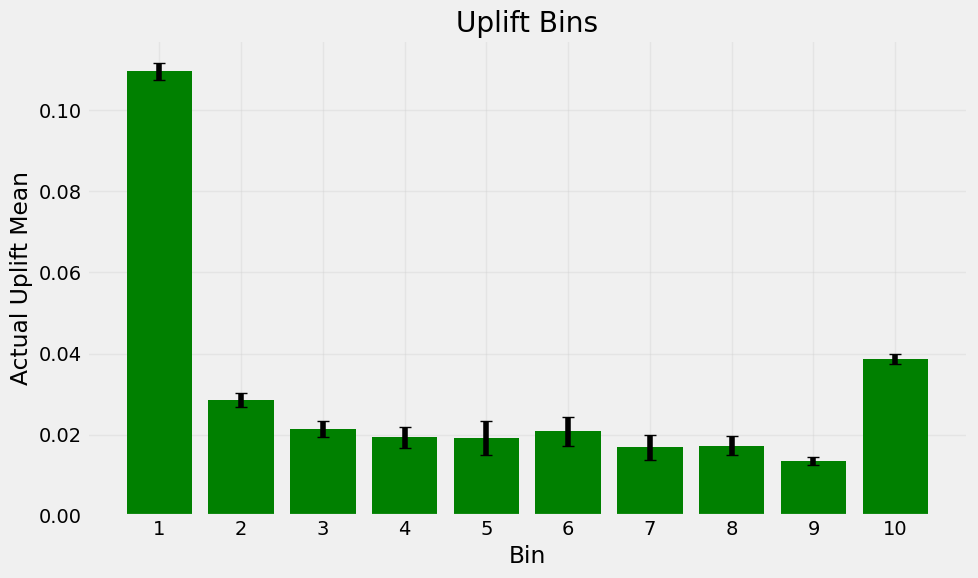

In [70]:
from src.viz import plot_uplift_bins

plot_uplift_bins(
    eval_df["t"],
    eval_df["y"],
    eval_df["tau"],
)

## T-learner

In [71]:
from causalml.inference.meta import BaseTClassifier

model_t = BaseTClassifier(
    learner=LGBMClassifier()
)
model_t.fit(X_train, t_train, y_train)

[LightGBM] [Info] Number of positive: 14175, number of negative: 10826866
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set: 10841041, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001308 -> initscore=-6.638306
[LightGBM] [Info] Start training from score -6.638306
[LightGBM] [Info] Number of positive: 18358, number of negative: 324274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2042
[LightGBM] [Info] Number of data points in the train set: 342632, number of used features: 12
[LightGBM]

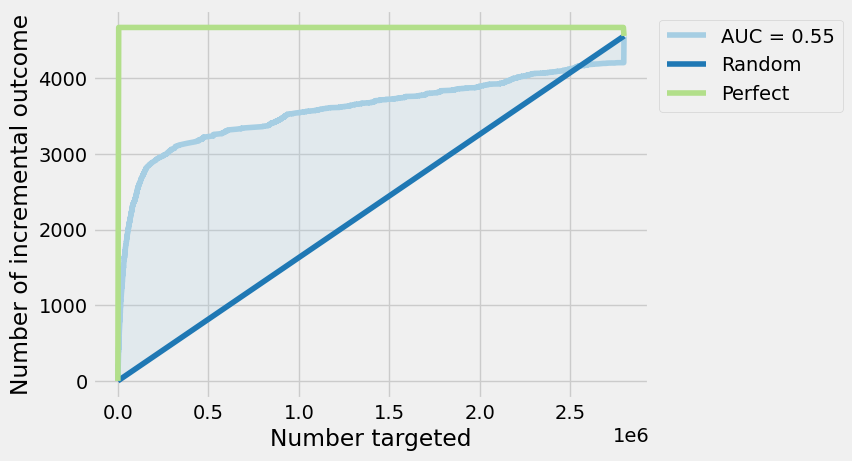

In [72]:
plot_qini_curve(
    y_test,
    model_t.predict(X_test).reshape(-1),
    t_test,
)

<Axes: title={'center': 'Uplift Bins'}, xlabel='Bin', ylabel='Actual Uplift Mean'>

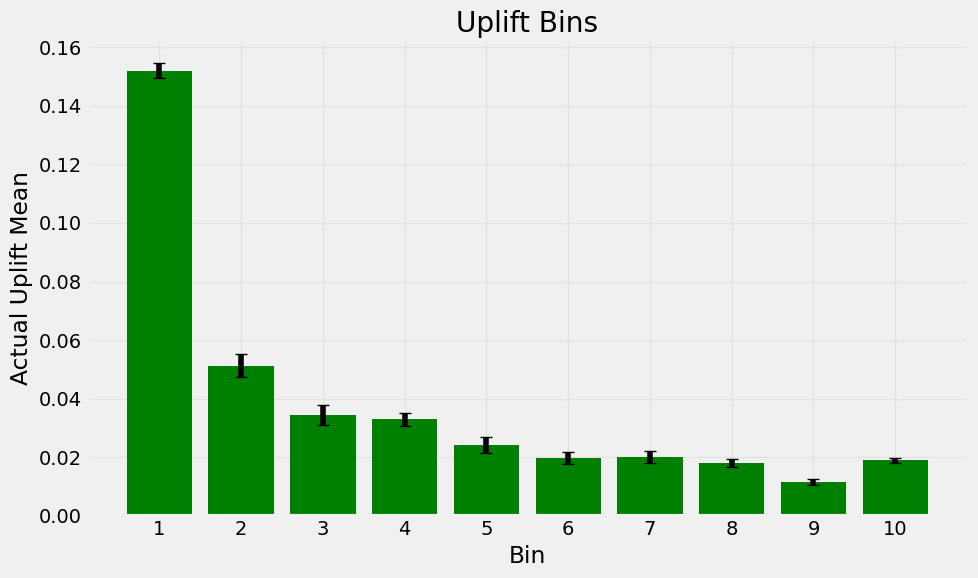

In [73]:
plot_uplift_bins(
    t_test,
    y_test,
    model_t.predict(X_test).reshape(-1),
)